In [134]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [135]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [136]:
data = torch.load("/kaggle/input/bh-data-2/train_dataset.pt")
X0_X1, Y1_Y2 = data.tensors
X0_X1.shape, Y1_Y2.shape

(torch.Size([100000, 1, 50, 2]), torch.Size([100000, 1, 50, 2]))

In [137]:
epochs = 10
batch_size = 32
k = 2

In [138]:
train_dataset = TensorDataset(X0_X1, Y1_Y2)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

In [139]:
latent_dim = 128
hidden_dim_1 = 100 # Fixed
hidden_dim_2 = 200 # Fixed
hidden_dim_3 = 400
hidden_dim_4 = 100
no_of_points = 50
no_of_functions = 2

In [140]:
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim_1, hidden_dim_2, hidden_dim_3, hidden_dim_4):
        super(Generator, self).__init__()
        self.L1 = nn.Linear(latent_dim, hidden_dim_1)
        
        self.L2 = nn.Linear(hidden_dim_2, hidden_dim_3)

        self.L3 = nn.Linear(hidden_dim_3, hidden_dim_4)

        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU(0.1)
        
    def forward(self, noise, cond):
        x = self.relu(self.L1(noise))
        x = torch.cat([x, cond.view(-1, hidden_dim_1)], dim=1)
        x = self.leaky_relu(self.L2(x))
        x = self.relu(self.L3(x))
        x = x.view(-1, 1, no_of_points, no_of_functions)
        return x

In [141]:
generator = Generator(latent_dim, hidden_dim_1, hidden_dim_2, hidden_dim_3, hidden_dim_4)

In [142]:
in_dim_g = 100
hidden_dim_1_g = 400
hidden_dim_2_g = 100
hidden_dim_3_g = 200
hidden_dim_4_g = 128
hidden_dim_5_g = 32
hidden_dim_6_g = 1

In [143]:
class Discriminator(nn.Module):
    def __init__(self, in_dim_g, hidden_dim_1_g, hidden_dim_2_g, hidden_dim_3_g, hidden_dim_4_g, hidden_dim_5_g, hidden_dim_6_g):
        super(Discriminator, self).__init__()

        self.L1 = nn.Linear(in_dim_g, hidden_dim_1_g)

        self.L2 = nn.Linear(hidden_dim_1_g, hidden_dim_2_g)

        self.L3 = nn.Linear(hidden_dim_3_g, hidden_dim_4_g)

        self.L4 = nn.Linear(hidden_dim_4_g, hidden_dim_5_g)

        self.L5 = nn.Linear(hidden_dim_5_g, hidden_dim_6_g)

        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU(0.1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, cond):
        
        x = x.view(-1, in_dim_g)
        x = self.relu(self.L1(x))
        x = self.leaky_relu(self.L2(x))
        x = torch.cat([x, cond.view(-1, hidden_dim_2_g)], dim=1)
        x = self.relu(self.L3(x))
        x = self.leaky_relu(self.L4(x))
        x = self.sigmoid(self.L5(x))
        
        return x

In [144]:
discriminator = Discriminator(in_dim_g, hidden_dim_1_g, hidden_dim_2_g, hidden_dim_3_g, hidden_dim_4_g, hidden_dim_5_g, hidden_dim_6_g)

In [145]:
optimizer_g = torch.optim.Adam(generator.parameters(), lr=0.0001)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.001)

In [146]:
criterion = nn.BCELoss()

In [147]:
def create_noise(no_samples, latent_dim):
    return torch.randn(no_samples, latent_dim).to(device)

In [148]:
def label_real(size):
    return torch.ones(size, 1).to(device)
    
def label_fake(size):
    return torch.zeros(size, 1).to(device)

In [149]:
def f_y_1(x0, x1):
    return torch.cos(49 * x0 + 63 * x1)

def f_y_2(x0, x1):
    return torch.cos(4 * x0 + 8 * x1)

In [150]:
def train_discriminator(optimizer, generated_sample, cond, real_sample):
    size = generated_sample.shape[0]
    real_label = label_real(size)
    fake_label = label_fake(size)
    recon_loss_fn = torch.nn.L1Loss(reduction='mean')
    x_loss = recon_loss_fn(real_sample, generated_sample)
    x0 = generated_sample[:,:,:,0]
    x1 = generated_sample[:,:,:,1]
    y1 = f_y_1(x0, x1)
    y2 = f_y_2(x0, x1)
    y1 = y1.view(-1, 1, 50, 1)
    y2 = y2.view(-1, 1, 50, 1)
    y_hat = torch.cat([y1, y2], dim=3)
    y_loss = recon_loss_fn(cond, y_hat)
    optimizer.zero_grad()
    out_real = discriminator(real_sample, cond)
    loss_real = criterion(out_real, real_label)
    out_fake = discriminator(generated_sample, cond)
    loss_fake = criterion(out_fake, fake_label)
    loss = x_loss + y_loss + loss_real + loss_fake
    loss.backward()
    optimizer.step()
    return loss

In [151]:
def train_generator(optimizer, fake_data, cond):
    size = fake_data.shape[0]
    real_label = label_real(size)
    recon_loss_fn = torch.nn.L1Loss(reduction='mean')
    x0 = fake_data[:,:,:,0]
    x1 = fake_data[:,:,:,1]
    y1 = f_y_1(x0, x1)
    y2 = f_y_2(x0, x1)
    y1 = y1.view(-1, 1, 50, 1)
    y2 = y2.view(-1, 1, 50, 1)
    y_hat = torch.cat([y1, y2], dim=3)
    y_loss = recon_loss_fn(cond, y_hat)
    optimizer.zero_grad()
    output = discriminator(fake_data, cond)
    loss = criterion(output, real_label)
    loss += y_loss
    loss = loss * 0.5
    loss.backward()
    optimizer.step()
    return loss

In [152]:
losses_g = []
losses_d = []

In [153]:
generator.train(),discriminator.train()

(Generator(
   (L1): Linear(in_features=128, out_features=100, bias=True)
   (L2): Linear(in_features=200, out_features=400, bias=True)
   (L3): Linear(in_features=400, out_features=100, bias=True)
   (relu): ReLU()
   (leaky_relu): LeakyReLU(negative_slope=0.1)
 ),
 Discriminator(
   (L1): Linear(in_features=100, out_features=400, bias=True)
   (L2): Linear(in_features=400, out_features=100, bias=True)
   (L3): Linear(in_features=200, out_features=128, bias=True)
   (L4): Linear(in_features=128, out_features=32, bias=True)
   (L5): Linear(in_features=32, out_features=1, bias=True)
   (relu): ReLU()
   (leaky_relu): LeakyReLU(negative_slope=0.1)
   (sigmoid): Sigmoid()
 ))

In [154]:
generator = generator.to(device)
discriminator = discriminator.to(device)

In [155]:
for epoch in range(epochs):
    loss_g = 0
    loss_d = 0
    for batch in tqdm(train_loader):
        x0_x1, y1_y2 = batch
        x0_x1, y1_y2 = x0_x1.to(device), y1_y2.to(device)
        no_samples = len(x0_x1)
        for step in range(k):
            generated_sample = generator(create_noise(no_samples, latent_dim), y1_y2)
            real_sample = x0_x1.to(device)
            loss_d += train_discriminator(optimizer_d, generated_sample, y1_y2, real_sample)
        fake_data = generator(create_noise(no_samples, latent_dim), y1_y2)
        loss_g += train_generator(optimizer_g, fake_data, y1_y2)
    loss_g /= len(train_loader)
    loss_d /= len(train_loader)
    losses_g.append(loss_g)
    losses_d.append(loss_d)
    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {loss_g:.8f}, Discriminator loss: {loss_d:.8f}")

  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 1 of 10
Generator loss: 3.96976781, Discriminator loss: 2.57210875


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 2 of 10
Generator loss: 3.13410616, Discriminator loss: 2.69838095


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 3 of 10
Generator loss: 2.76596141, Discriminator loss: 3.01277900


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 4 of 10
Generator loss: 2.42008066, Discriminator loss: 3.07441878


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 5 of 10
Generator loss: 2.41668344, Discriminator loss: 3.11209440


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 6 of 10
Generator loss: 1.45046592, Discriminator loss: 3.51200056


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 7 of 10
Generator loss: 1.65822947, Discriminator loss: 3.31525278


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 8 of 10
Generator loss: 2.31153631, Discriminator loss: 2.97916532


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 9 of 10
Generator loss: 2.65462995, Discriminator loss: 2.79600620


  0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 10 of 10
Generator loss: 3.13277078, Discriminator loss: 2.53678441


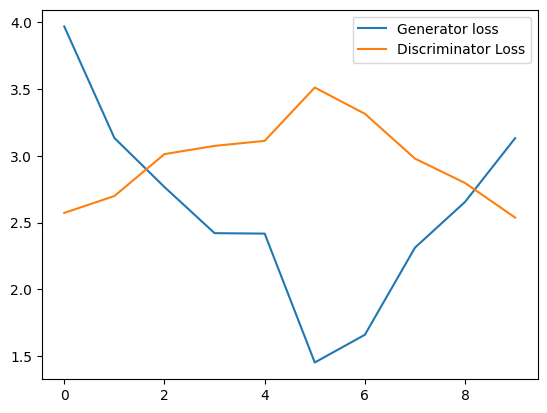

In [156]:
losses_g_tensor = torch.tensor(losses_g)
losses_d_tensor = torch.tensor(losses_d)

plt.figure()
plt.plot(losses_g_tensor.detach().numpy(), label='Generator loss')
plt.plot(losses_d_tensor.detach().numpy(), label='Discriminator Loss')
plt.legend()

In [157]:
for batch in train_loader:
    x1_x2, y1_y2 = batch 
    break

In [158]:
def plot_samples(num_samples, x0_x1, y1_y2):
    x0_x1 = x0_x1.to("cpu")
    y1_y2 = y1_y2.to("cpu")
    for i in range(num_samples):
        
        x0 = x0_x1[i,0,:,0]
        x1 = x0_x1[i,0,:,1]
        y1 = y1_y2[i,0,:,0]
        y2 = y1_y2[i,0,:,1]
        y1_hat = f_y_1(x0, x1)
        y2_hat = f_y_2(x0, x1)
        plt.plot(x0.detach().numpy(), label="X0")
        plt.plot(x1.detach().numpy(), label="X1")
        plt.plot(y1.detach().numpy(), label="Y1")
        plt.plot(y2.detach().numpy(), label="Y2")
        plt.plot(y1_hat.detach().numpy(), label="Y1_hat")
        plt.plot(y2_hat.detach().numpy(), label="Y2_hat")
        plt.legend()
        plt.show()

In [159]:
def f_y_1(x0, x1):
    return torch.cos(49 * x0 + 63 * x1)

def f_y_2(x0, x1):
    return torch.cos(4 * x0 + 8 * x1)

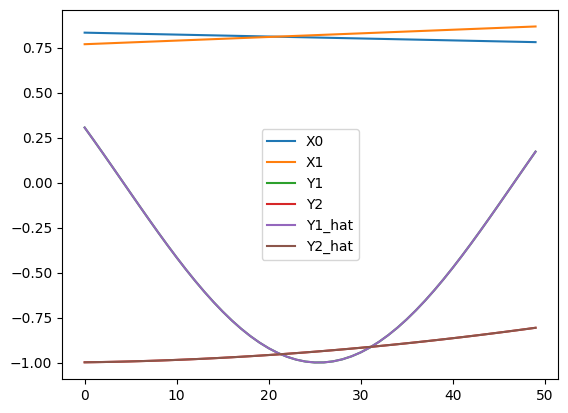

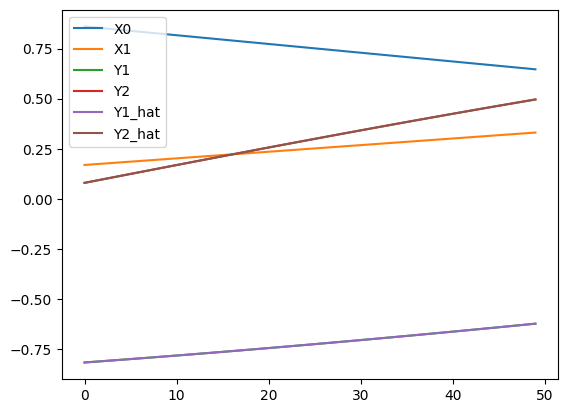

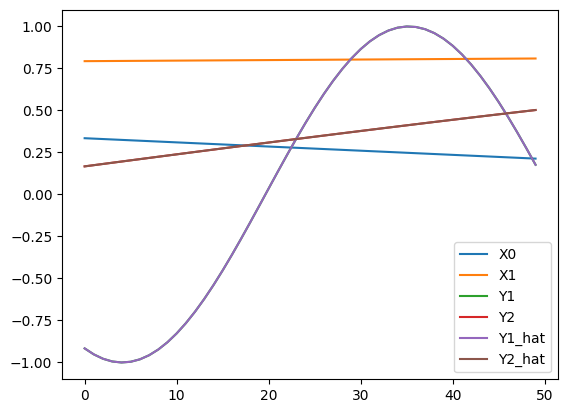

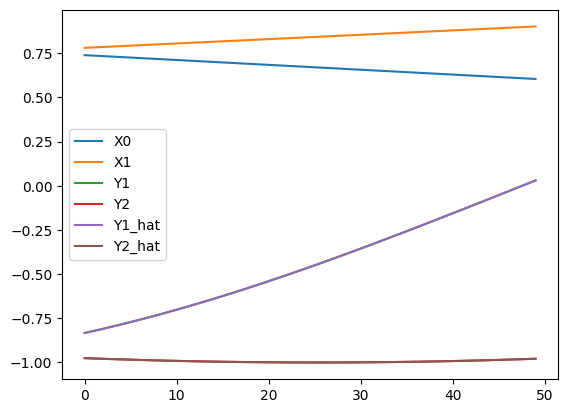

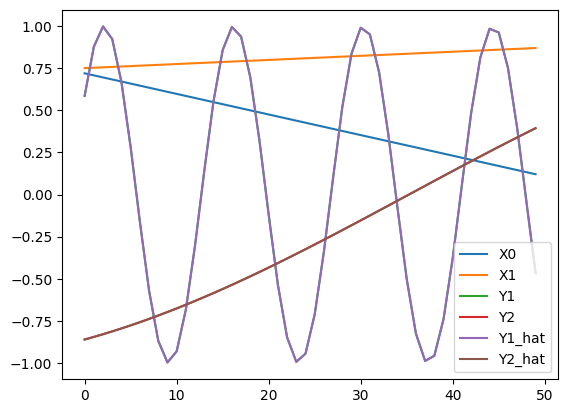

In [160]:
num_samples=5
plot_samples(num_samples, x1_x2, y1_y2)

In [161]:
generator.eval()
discriminator.eval()
def generate_samples(num_samples, given_y):
    samples = torch.tensor([])
    samples = samples.to(device)
    givens = torch.tensor([])
    givens = givens.to(device)
    given_y = given_y.to(device)
    with torch.no_grad():
        for i, _ in enumerate(range(num_samples)):
            sample = generator(create_noise(1, latent_dim), given_y[i,:,:,:].unsqueeze(0))
            samples = torch.cat([samples, sample], dim=0)   
            
    givens = torch.cat([givens, given_y], dim=0) 

    return samples, givens

In [162]:
num_samples = 5
for batch in train_loader:
    x1_x2, y1_y2 = batch 
    y_givens = y1_y2[:5,:,:,:]
    break

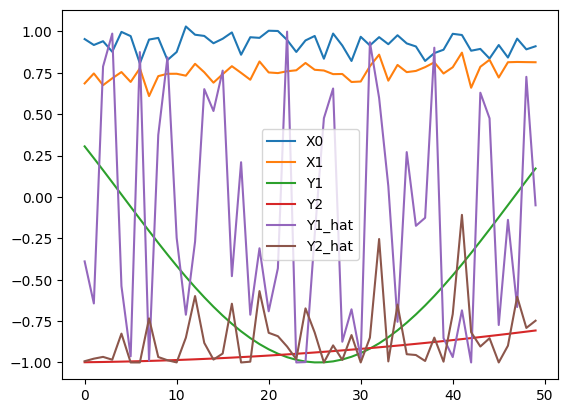

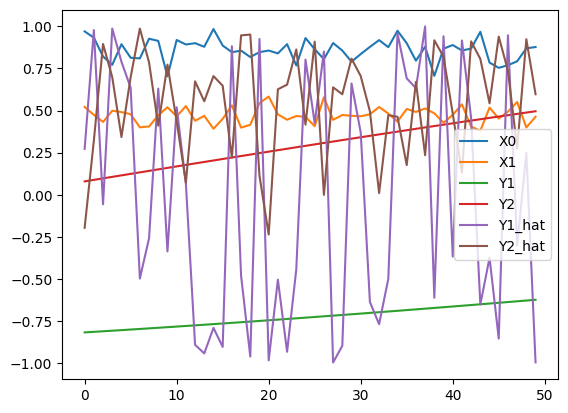

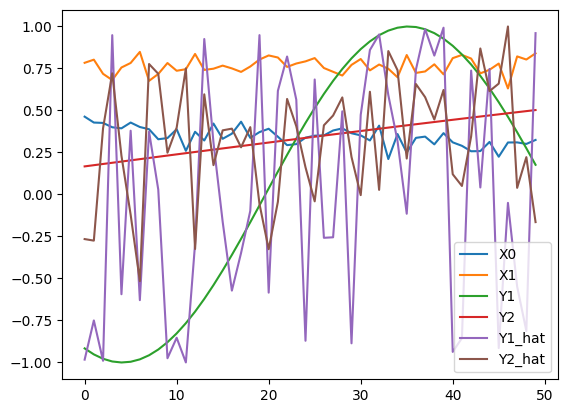

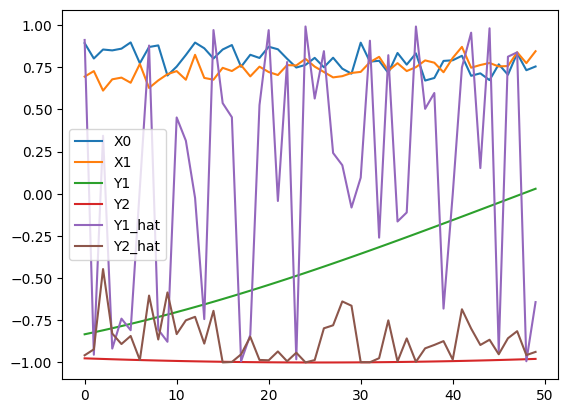

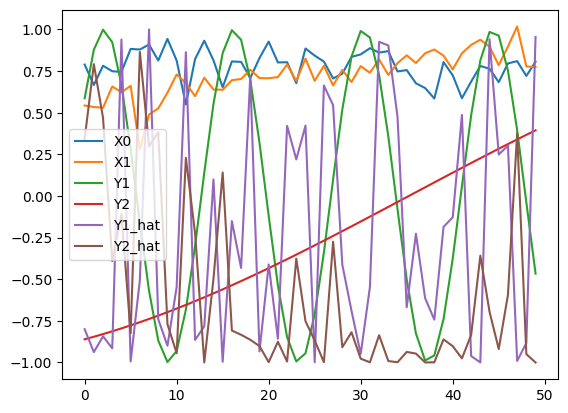

In [163]:
samples, givens = generate_samples(num_samples, y_givens)
plot_samples(num_samples, samples, givens)